In [ ]:
# Importing the relevant packages
import tensorflow as tf
import tensorflow_datasets as tfds

# **Identify**

In [ ]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 50
NUM_EPOCHS = 50

In [ ]:
# Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [ ]:
# Creating a function to scale our image data (it is recommended to scale the pixel values in the range [0,1] )
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [ ]:
# Scaling the data
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [ ]:
# Defining the size of the validation set
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [ ]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [ ]:
# Reshuffling the dataset
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [ ]:
# Splitting the dataset into training + validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [ ]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

**Create a Model Train**

In [ ]:
# Outlining the model/architecture of our CNN
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    # (2,2) is the default pool size so we could have just used MaxPooling2D() with no explicit arguments
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, see below for comentary
])

In [ ]:
# A brief summary of the model and parameters
model.summary(line_length = 100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 24, 24, 50)                      1300           
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 12, 12, 50)                      0              
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 10, 10, 50)                      22550          
                                                                                                    
 max_pooling2d_1 (MaxPooling2D)              (None, 5, 5, 50)                        0              
                                                                       

In [ ]:
# Defining the loss function

# In general, our model needs to output probabilities of each class, 
# which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [ ]:
# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

# Alternate early_stopping
# tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     min_delta=0,
#     patience=0,
#     verbose=0,
#     mode='auto',
#     baseline=None,
#     restore_best_weights=False,
#     start_from_epoch=0
# )

In [ ]:
# Train the network
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/50
1080/1080 - 18s - loss: 0.1755 - accuracy: 0.9485 - val_loss: 0.0555 - val_accuracy: 0.9828 - 18s/epoch - 16ms/step
Epoch 2/50
1080/1080 - 6s - loss: 0.0511 - accuracy: 0.9839 - val_loss: 0.0307 - val_accuracy: 0.9898 - 6s/epoch - 6ms/step
Epoch 3/50
1080/1080 - 6s - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.0315 - val_accuracy: 0.9920 - 6s/epoch - 6ms/step
Epoch 4/50
1080/1080 - 6s - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.0253 - val_accuracy: 0.9928 - 6s/epoch - 6ms/step
Epoch 5/50
1080/1080 - 6s - loss: 0.0259 - accuracy: 0.9920 - val_loss: 0.0150 - val_accuracy: 0.9963 - 6s/epoch - 6ms/step
Epoch 6/50
1080/1080 - 9s - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0134 - val_accuracy: 0.9957 - 9s/epoch - 8ms/step
Epoch 7/50
1080/1080 - 6s - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.0103 - val_accuracy: 0.9967 - 6s/epoch - 6ms/step
Epoch 8/50
1080/1080 - 6s - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0167 - val_accuracy: 0.9952 - 6s/epoch - 6ms/step
Epoch

Test Model

In [ ]:
# Testing our model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.0321 - accuracy: 0.9910


In [ ]:
# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0321. Test accuracy: 99.10%


**Plot Image and Result**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Split the test_data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

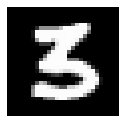

Label: 3


In [ ]:
# The image to be displayed and tested
i = 9


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 44ms/step


<BarContainer object of 10 artists>

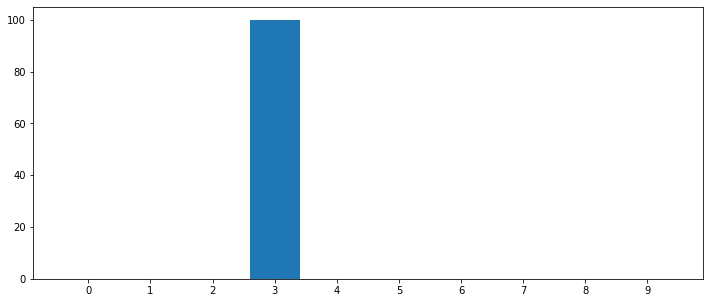

In [ ]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])